In [1]:
import numpy as np

# Needed for plotting
import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Needed for generating training and testing datasets
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score

np.random.seed(1234)

### Setup Dataset

In [2]:
nsample = 10000
sig = 0.5
x = np.linspace(0, 20, nsample)

X = np.column_stack((x, np.ones(nsample)))
beta = [5, 3]

#X = np.column_stack((x, x np.ones(nsample))) # ---> Multicollinearity: OLS breaks down without pseudo inverse
#beta = [5, 2, 3]

#X = np.column_stack((x, x**2, np.ones(nsample))) # ---> Batch Gradient Descent breaks down
#beta = [5, 2, 3]

#X = np.column_stack((x, x**2, np.sin(x), np.ones(nsample)))
#beta = [5, 2, 7, 3]


y_true = np.dot(X, beta)
y = y_true + sig * np.random.normal(size=nsample)

In [5]:
X

array([[0.00000000e+00, 1.00000000e+00],
       [2.00020002e-03, 1.00000000e+00],
       [4.00040004e-03, 1.00000000e+00],
       ...,
       [1.99959996e+01, 1.00000000e+00],
       [1.99979998e+01, 1.00000000e+00],
       [2.00000000e+01, 1.00000000e+00]])

### Train Test Split

In [3]:
# split the dataset into train and test sets
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
# print train and test set shapes
print(f"X_train:{X_train.shape}\ny_train:{y_train.shape}")

X_train:(9000, 2)
y_train:(9000,)


## Ordinary Least Squares

In [4]:
%matplotlib inline

In [5]:
res = sm.OLS(y_train, X_train).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.450e+07
Date:                Fri, 11 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:34:36   Log-Likelihood:                -6493.9
No. Observations:                9000   AIC:                         1.299e+04
Df Residuals:                    8998   BIC:                         1.301e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             4.9991      0.001   4949.540      0.0

In [6]:
print("Analytically computing the parameters:")
print(np.linalg.inv(X_train.T@X_train)@X_train.T@y_train)

Analytically computing the parameters:
[4.99908254 3.01664684]


In [7]:
print("Parameters: ", res.params)
print("Standard errors: ", res.bse)
print("R_squared value: ", res.rsquared)
print("Testing Accuracy:{}".format(r2_score(res.predict(X_test), y_test)))

Parameters:  [4.99908254 3.01664684]
Standard errors:  [0.00101001 0.0104965 ]
R_squared value:  0.9996328388279154
Testing Accuracy:0.9706191582176014


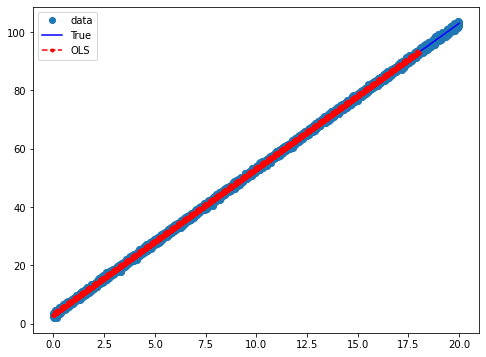

In [8]:
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x, y, "o", label="data")
ax.plot(x, y_true, "b-", label="True")
ax.plot(X_train[:, 0], res.fittedvalues, "r--.", label="OLS")
ax.plot(X_train[:, 0], iv_u, "r--")
ax.plot(X_train[:, 0], iv_l, "r--")
ax.legend(loc="best")

## Gradient Descent

In [9]:
import numpy as np
import matplotlib.pyplot as plt

class Regressor():
    def __init__(self, learning_rate=0.01, tol=0.01, seed=None,normalize=False):
        self.W = None
        self.b = None
        self.__lr = learning_rate
        self.__tol = tol
        self.__length = None
        self.__normalize = normalize
        self.__m = None
        self.__costs = []
        self.__iterations = []
        self.__ws = []
        self.__bs = []
        np.random.seed(seed if seed is not None else np.random.randint(100))

    def __initialize_weights_and_bias(self):
        self.W = np.random.randn(self.__length) #(n,1)
        self.b = 0
        self.__ws.append(self.W)
        self.__bs.append(self.b)

    def __computeCost(self,h,Y):
        loss = np.square(h-Y)
        cost = np.sum(loss)/(2*self.__m)
        return cost

    def __optimize(self,X,Y):
        h = np.dot(X,self.W)+self.b
        dW = np.dot( X.T, (h-Y) ) / self.__m
        db = np.sum( h-Y )  / self.__m
        self.W = self.W - self.__lr*dW
        self.b = self.b - self.__lr*db

    def __normalizeX(self,X):return (X-self.__mean) / (self.__std)

    def fit(self, X, y, verbose=True):
        if self.__normalize:
            self.__mean, self.__std = X.mean(axis=0), X.std(axis=0)
            X = self.__normalizeX(X)
        self.__m,self.__length = X.shape
        self.__initialize_weights_and_bias()
        last_cost,i = float('inf'),0
        while True:
            h = np.dot(X,self.W)+self.b
            cost = self.__computeCost(h,y)
            if verbose: print(f"Iteration: {i}, Cost: {cost:.3f}")
            self.__optimize(X,y)
            if last_cost-cost < self.__tol: break
            else: last_cost,i = cost,i+1
            self.__costs.append(cost)
            self.__iterations.append(i)

    def predict(self,X):

        if self.__normalize: X = self.__normalizeX(X)
        return np.dot(X,self.W)+self.b
    
    def seq_fit(self, X, y, verbose=True):
        if self.__normalize:
            self.__mean, self.__std = X.mean(axis=0), X.std(axis=0)
            X = self.__normalizeX(X)
        self.__m,self.__length = X.shape
        self.__initialize_weights_and_bias()
        last_cost,j = float('inf'),0
        while True:
            cost=0
            for i in range(len(X)):
                h = np.dot(X[i],self.W)+self.b
                cost += self.__computeCost(h,y[i])
                self.__optimize(X[i],y[i])

            if verbose: print(f"Iteration: {j}, Cost: {cost:.3f}")
            if last_cost-cost < self.__tol: break
            else: last_cost,j = cost,j+1
            self.__costs.append(cost)
            self.__iterations.append(j)     

    def plot(self,figsize=(7,5)):
        plt.figure(figsize=figsize)
        plt.plot(self.__iterations,self.__costs)
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.title("Iterations vs Cost")
        plt.show()

    def score(self,X,y):
        return 1-(np.sum(((y-self.predict(X))**2))/np.sum((y-np.mean(y))**2))

### Batch Gradient Descent

X_train:(9000, 2)
y_train:(9000,)
Iteration: 0, Cost: 1880.591
Iteration: 1, Cost: 17.336
Iteration: 2, Cost: 0.481
Iteration: 3, Cost: 0.327
Iteration: 4, Cost: 0.324
Train Score: 0.9990860578023572
Test Score:  0.90842562256362


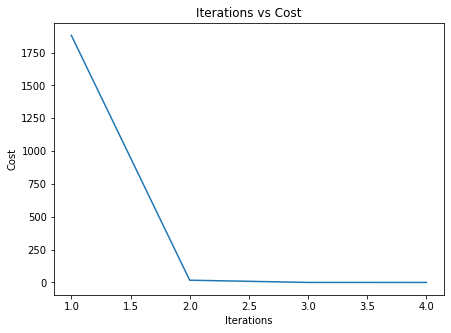

In [10]:
print(f"X_train:{X_train.shape}\ny_train:{y_train.shape}")

batch_regressor = Regressor(normalize=False)
batch_regressor.fit(X_train,y_train)

train_score = r2_score(batch_regressor.predict(X_train),y_train)
test_score = r2_score(batch_regressor.predict(X_test),y_test)

print("Train Score:", train_score)
print("Test Score: ",test_score)
batch_regressor.plot()

### Sequential Gradient Descent

X_train:(9000, 2)
y_train:(9000,)
Iteration: 0, Cost: 472.460
Iteration: 1, Cost: 53.314
Iteration: 2, Cost: 6.211
Iteration: 3, Cost: 0.870
Iteration: 4, Cost: 0.248
Iteration: 5, Cost: 0.170
Iteration: 6, Cost: 0.159
Iteration: 7, Cost: 0.156
Train Score: 0.9995421939070451
Test Score:  0.9662636015440792


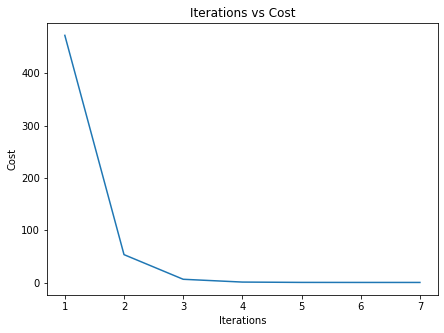

In [11]:
print(f"X_train:{X_train.shape}\ny_train:{y_train.shape}")

seq_regressor = Regressor(normalize=False)
seq_regressor.seq_fit(X_train,y_train)

train_score = r2_score(seq_regressor.predict(X_train),y_train)
test_score = r2_score(seq_regressor.predict(X_test),y_test)

print("Train Score:", train_score)
print("Test Score: ",test_score)
seq_regressor.plot()

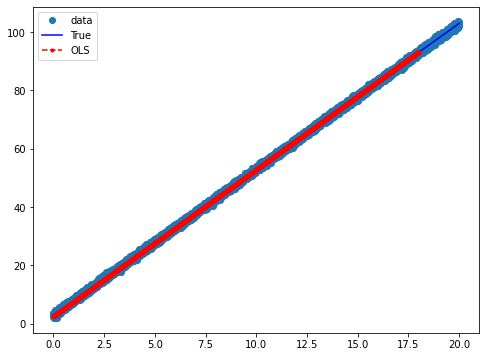

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x, y, "o", label="data")
ax.plot(x, y_true, "b-", label="True")
ax.plot(X_train[:, 0], seq_regressor.predict(X_train), "r--.", label="OLS")
ax.legend(loc="best")